In [1]:
import tensorflow as tf
import numpy as np
import sys
import os
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath("/notebooks"))
import sq_net

Our lstm cells have an internal size - hidden size
And a size that matches the input    - input size

We can change the cell() defintion to try out other cell types

In [2]:
hidden_size = 32
input_size = 35
output_size = 26
layer_count = 3
train_steps = 120
batch_size = 16
input_count = 4

#beta is the regularization
beta_val = 0.0002
beta = tf.Variable(beta_val, trainable=False)
train_length = train_steps - input_size - 1

cell_name = "gru_cell"
cell_kernel = "{0}/gates".format(cell_name)

global_dropout = tf.Variable(0.9, trainable=False)

# gru_cell/gates, basic_lstm_cell
def cell():
    lcell = tf.nn.rnn_cell.GRUCell(hidden_size)
    return tf.nn.rnn_cell.DropoutWrapper(lcell, input_keep_prob=global_dropout)

Set up the network and a trainer

In [3]:
loss, cost, logits, save_dict = sq_net.sequence_layer(train_steps, batch_size, input_size, output_size, \
                        input_count, layer_count, hidden_size, cell, cell_kernel, beta, global_dropout, None)

inputs = save_dict['inputs']

In [4]:
train_op, grads = sq_net.adam_train(cost)

Import the AirQuality data from the csv file

In [5]:
filename_queue = tf.train.string_input_producer(["data/AirQualityUCI.csv"])

reader = tf.TextLineReader(1)
key, value = reader.read_up_to(filename_queue, 8000)

In [6]:
# Date1;Time2;3CO(GT);4PT08.S1(CO);5NMHC(GT);6C6H6(GT);7PT08.S2(NMHC);8NOx(GT);9PT08.S3(NOx);10NO2(GT);11PT08.S4(NO2);12PT08.S5(O3);12T;14RH;15AH;;
record_defaults = [["0"],["0"],["0"],["0"],["0"],["0"],["0"],["0"],["0"],["0"],["0"],["0"],["0"],["0"],["0"],["0"],["0"]]

cols = tf.decode_csv(value, record_defaults=record_defaults, field_delim=";")

ptco = tf.string_to_number(cols[3])
ptco_max = tf.reduce_max(ptco)
ptco_norm = ptco / ptco_max

nmhc = tf.string_to_number(cols[4])
nmhc_max = tf.reduce_max(nmhc)
nmhc_norm = nmhc / nmhc_max

# c6h6 = cols[5]

pts2 = tf.string_to_number(cols[6])
pts2_max = tf.reduce_max(pts2)
pts2_norm = pts2 / pts2_max

nox = tf.string_to_number(cols[7])
nox_max = tf.reduce_max(nox)
nox_norm = nox / nox_max

no2 = tf.string_to_number(cols[9])
no2_max = tf.reduce_max(no2)
no2_norm = no2 / no2_max

o3 = tf.string_to_number(cols[11])
o3_max = tf.reduce_max(o3)
o3_norm = o3 / o3_max

Read the data using a queue runner

In [7]:
with tf.Session() as sess:
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)

    full_data, ptco_norm_data, pts2_norm_data, nmhc_norm_data, \
        nox_data, nox_norm_data, no2_data, no2_norm_data, o3_data, o3_norm_data = \
        sess.run([cols, ptco_norm, pts2_norm, nmhc_norm, nox, nox_norm, no2, no2_norm, o3, o3_norm])
        
    coord.request_stop()
    coord.join(threads)

We can choose different gases to train with and target

In [8]:
training_set_a = pts2_norm_data[:8000]
training_set_b = ptco_norm_data[:8000]
training_set_c = nox_norm_data[:8000]
training_set_d = no2_norm_data[:8000]

target_set = o3_norm_data[:8000]

Our data feed will adjust based on the data we set with data_in

In [9]:
data_in = [training_set_a, training_set_b, training_set_c, training_set_d]

Lets look at some of the data

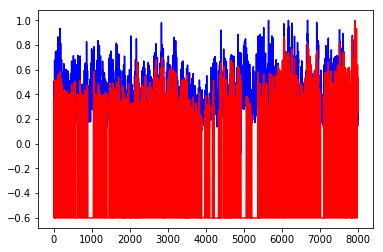

In [10]:
plt.plot(target_set, 'b')
plt.plot(training_set_d, 'r')
plt.show()

Grab a bunch of data for training/testing

In [11]:
def feed_data(iterations, steps):
    
    data_out = []
    for dataset in data_in:
        data_out.append([])
    
    targets = []
    
    for iteration in iterations:
        data_t = []
        
        d_out = []
        for dataset in data_out:
            d_out.append([])
        
        offset = iteration * train_length

        for i in range(steps):
            for idx, dataset in enumerate(data_in):
                data = d_out[idx]
                input_seq = dataset[offset + i : offset + i + input_size]
                data.append(input_seq)

            target_seq = target_set[offset + i + input_size : offset + i + input_size + output_size]
            data_t.append(target_seq)
            
        for idx, dataset in enumerate(data_out):
            dataset.append(d_out[idx])
            
        targets.append(data_t)

    return (offset, data_out, targets)

Set a few things up for the session

In [12]:
from random import sample

train_range = range(50)
total_cost = 0
last_loss = 0

currentSession = tf.Session()

merged = tf.summary.merge_all()
train_writer = tf.summary.FileWriter('summaries/train/b', currentSession.graph)

tf.global_variables_initializer().run(session = currentSession)

starting_epoch = 0

progress = 0

Play with different learning rates

In [16]:
def learning_schedule(step):
    flr = 0.005
    if (step > 6000):
        flr = 0.001
    if (step > 8000):
        flr = 0.0008
    if (step > 14000):
        flr = 0.0006
    if (step > 16000):
        flr = 0.0002
    if (step > 21000):
        flr = 0.00002
    return flr

In [14]:
def validate(validation_point):
    no_drop = tf.assign(global_dropout, 1.0)
    drop = currentSession.run(no_drop)

    test_offset = [] 
    #The network still wants batches at the moment
    for i in range(batch_size):
        test_offset.append(validation_point)
        
    offset, data_out, targets = feed_data(test_offset, train_steps)

    feed_dict={'targets:0': targets}
    for idx in range(input_count):
        feed_dict.update({inputs[idx].name: data_out[idx]})

    test_logits, current_loss, fstate = currentSession.run([logits, loss, save_dict['final_state']], feed_dict)

    distance = 25
    #predictions at different distances from the input
    far_away = test_logits[0][:,distance]
    mid = test_logits[0][:,7]
    close = test_logits[0][:,1]

    test_size = input_size + distance
    offset, data_out, targets = feed_data(test_offset, train_steps)
    ts = np.stack(targets[0])
    ts = np.array(targets[0])[:,0]
    
    return current_loss, far_away, ts

Start training - choose a dropout rate

In [18]:
drop_val = 0.8

dropit = tf.assign(global_dropout, drop_val)

drop = currentSession.run(dropit)

for epoch in range(starting_epoch, 395):
    starting_epoch = epoch
    
    iterations = []
    
    train_ranges = [] 
    
    epoch_loss = 0
    
    for i in range(batch_size):
        train_ranges.append(sample(train_range, 50))
        
    batch_offsets = np.reshape(train_ranges, (-1, batch_size))
    
    for offsets in batch_offsets:
        offset, data_out, targets = feed_data(offsets, train_steps)
        
        flr = learning_schedule(progress)
        
        feed = {'targets:0': targets, 'learning_rate:0': flr, dropit: drop_val}
        
        for idx in range(input_count):
            feed.update({inputs[idx].name: data_out[idx]})
        
        summary, partial_loss, train, fstate = currentSession.run([merged, loss, train_op, save_dict['final_state']], \
                                                                  feed_dict=feed)
        
        train_writer.add_summary(summary, progress)
        progress = progress + 1
        #allow a little time for initial variation to die down
        if epoch > 0:
            epoch_loss = epoch_loss + partial_loss
        
    total_cost = epoch_loss + total_cost
    
    if epoch % 30 == 0:
        running_loss = total_cost - last_loss
        last_loss = total_cost
        av_loss = epoch_loss / 50
        print(hidden_size, batch_size, beta_val, epoch_loss, epoch, running_loss, flr, av_loss, partial_loss)
        
        indices = 12
        val_range = sample(xrange(20), indices)
        validate_average = 0
        
        for value in val_range:
            validate_offset = value + 50
            validations, _, _ = validate(validate_offset)
            validate_average = validate_average + validations

        no_drop = tf.assign(global_dropout, 0.8)
        drop = currentSession.run(no_drop)
            
        print(validate_average / indices, val_range) 

(22, 16, 0.0002, 0.3133568037301302, 300, 9.8163413042202592, 0.0006, 0.006267136074602604, 0.0056910324)
(0.020415419712662697, [0, 8, 19, 18, 9, 15, 14, 5, 4, 6, 17, 12])
(22, 16, 0.0002, 0.30690161604434252, 330, 9.335203982423991, 0.0002, 0.0061380323208868499, 0.0060125538)
(0.024062525869036715, [10, 6, 12, 17, 14, 13, 16, 18, 2, 5, 11, 8])
(22, 16, 0.0002, 0.30609454261139035, 360, 9.1924056150019169, 0.0002, 0.006121890852227807, 0.0058105011)
(0.022401178876558941, [12, 8, 2, 1, 11, 6, 14, 15, 13, 4, 10, 9])
(22, 16, 0.0002, 0.30363314179703593, 390, 9.1560970405116677, 0.0002, 0.0060726628359407189, 0.0057852077)
(0.024297634682928521, [19, 11, 8, 1, 0, 13, 14, 15, 12, 7, 3, 4])

Results from previous run
(22, 4, 0.012, 0.75928797852247953, 30, 28.130740600638092, 0.001, 0.01518575957044959, 0.025324259)
(0.01991733970741431, [3, 5, 11, 6, 13, 16, 7, 2, 17, 10, 9, 1])
(22, 4, 0.012, 0.56991863530129194, 60, 19.984842267818749, 0.001, 0.011398372706025839, 0.0092041623)
(0.019945473720630009, [16, 10, 5, 1, 8, 11, 9, 6, 2, 3, 19, 15])
(22, 4, 0.012, 0.53841507947072387, 90, 16.683391402009875, 0.001, 0.010768301589414477, 0.012398911)
(0.020400462982555229, [9, 12, 16, 17, 7, 14, 4, 0, 8, 5, 15, 2])
(22, 4, 0.012, 0.35388133488595486, 120, 12.493187983520329, 0.001, 0.007077626697719097, 0.011706958)
(0.022565561967591446, [0, 17, 3, 6, 4, 7, 15, 19, 5, 8, 16, 18])
(22, 4, 0.012, 0.31174778053537011, 150, 11.304671347606927, 0.001, 0.0062349556107074025, 0.0073217414)
(0.021213628894959886, [6, 19, 4, 2, 15, 5, 0, 17, 16, 12, 9, 7])
(22, 4, 0.012, 0.54646076308563352, 210, 18.03114574495703, 0.0008, 0.01092921526171267, 0.0089054992)
(0.018522994980836909, [10, 12, 18, 9, 5, 2, 11, 13, 15, 4, 3, 7])


*******
(22, 8, 0.016, 0, 0, 0, 0.001, 0, 0.026430946)
(0.032205939525738358, [15, 11, 1, 12, 8, 6, 9, 3, 2, 18, 4, 13])
(22, 8, 0.016, 0.77701491117477417, 30, 27.029327136464417, 0.001, 0.015540298223495484, 0.012644939)
(0.022979985301693279, [13, 5, 0, 14, 12, 1, 4, 7, 11, 2, 17, 6])
(22, 8, 0.016, 0.73235377483069897, 60, 23.532660925760865, 0.001, 0.01464707549661398, 0.015665311)
(0.019436083035543561, [3, 2, 6, 7, 12, 5, 15, 17, 9, 0, 10, 11])
(22, 8, 0.016, 0.6555849714204669, 90, 20.78133162483573, 0.001, 0.013111699428409338, 0.012796191)
(0.020664084004238248, [14, 7, 9, 8, 6, 4, 3, 12, 16, 5, 13, 18])
(22, 8, 0.016, 0.72552435472607613, 120, 20.182675201445818, 0.001, 0.014510487094521523, 0.010681516)
(0.019372141221538186, [11, 0, 6, 8, 17, 16, 14, 10, 5, 7, 2, 3])
(22, 8, 0.016, 0.57952790893614292, 150, 18.611567541956902, 0.001, 0.011590558178722858, 0.012818389)
(0.021197795247038204, [13, 19, 4, 7, 18, 10, 0, 1, 11, 9, 12, 15])
(22, 8, 0.016, 0.59323347639292479, 180, 17.638431374449283, 0.001, 0.011864669527858496, 0.013732762)
(0.022313984188561637, [15, 7, 0, 10, 16, 13, 8, 4, 2, 14, 12, 5])
(22, 8, 0.016, 0.55298889242112637, 210, 17.036189836449921, 0.0008, 0.011059777848422526, 0.0091538271)
(0.023156357385839026, [14, 19, 13, 0, 8, 3, 18, 7, 1, 11, 16, 5])
(22, 8, 0.016, 0.50631409976631403, 240, 15.846848386339843, 0.0008, 0.010126281995326281, 0.0092495885)
(0.020125681301578879, [0, 12, 16, 14, 19, 4, 1, 5, 7, 3, 9, 15])
(22, 8, 0.016, 0.70553555712103844, 270, 17.684835837222636, 0.0008, 0.014110711142420769, 0.012239807)
(0.018002962383131187, [7, 4, 12, 19, 6, 2, 11, 9, 8, 1, 10, 5])
(22, 8, 0.016, 0.65702436957508326, 300, 21.372702517546713, 0.0008, 0.013140487391501665, 0.01766105)
(0.027398040673385065, [8, 18, 12, 7, 1, 19, 2, 9, 14, 6, 0, 4])
(22, 8, 0.016, 0.60001945402473211, 330, 19.56549764610827, 0.0008, 0.012000389080494642, 0.012756304)
(0.023783902171999216, [12, 14, 1, 4, 18, 17, 3, 9, 10, 0, 8, 2])
(22, 8, 0.016, 0.76574821677058935, 360, 17.596865852829069, 0.0008, 0.015314964335411787, 0.015783155)
(0.023949965989838045, [14, 17, 13, 3, 6, 12, 4, 16, 8, 15, 0, 7])
(22, 8, 0.016, 0.6361575610935688, 390, 20.046616850420833, 0.0006, 0.012723151221871376, 0.012433306)
(0.023572704754769802, [5, 0, 9, 6, 14, 7, 18, 8, 1, 16, 12, 10])

It's simple to train and restart

In [19]:
saver = tf.train.Saver()
saver.save(currentSession, 'checkpoints/{0}_{1}'.format(cell_name, epoch))

'checkpoints/gru_cell_394'

Without having to create a new network we can take a look at how things are going

We can plot the predictions at different prediction points

0.0160164


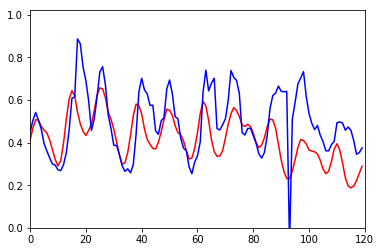

In [32]:
validations, far_away, ts = validate(57)

print(validations)

import matplotlib.pyplot as plt
plt.plot(far_away, 'r')
# plt.plot(mid[18:], 'y')
# plt.plot(close[25:], 'g')
plt.plot(ts, 'b')
plt.axis([0.0,train_steps,0.0,1.02])
plt.show()

Some example results at offset 57
0.0123539 (22, 4, 0.012, 0.54646076308563352, 210, 18.03114574495703, 0.0008, 0.01092921526171267, 0.0089054992)
(16, 0.007, 'offset', [57, 57, 57, 57], 4788, 26, 0.014154767, 126)
(16, 0.006, 'offset', [57, 57, 57, 57], 4788, 26, 0.015169268, 122)
(16, 0.006, 'offset', [57, 57, 57, 57], 4788, 26, 0.015310187, 98)
(16, 0.004, 'offset', [57, 57, 57, 57], 4788, 26, 0.01529764, 66)
(16, 0.002, 'offset', [57, 57, 57, 57], 4788, 26, 0.017894622, 195)
(16, 0.002, 'offset', [57, 57, 57, 57], 4788, 26, 0.01718206, 160)
(16, 0.002, 'offset', [57, 57, 57, 57], 4788, 26, 0.019261345, 122)

In [21]:
saver = tf.train.Saver()
saver.save(currentSession, 'checkpoints/predict{0}_{1}'.format(batch_size, epoch))

'checkpoints/predict16_394'

We're now going to save the batching network and create a different network with batch size 1 and 1 training step which we can use for making predictions from a stream

In [22]:
p_batch = 1
    
p_loss, p_cost, p_logits, p_save_dict = sq_net.sequence_layer(1, p_batch, input_size, output_size, \
                       input_count, layer_count, hidden_size, cell, cell_kernel, beta, False, True)

p_inputs = p_save_dict['inputs']

In [23]:
sess = tf.Session()  
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()
saver.restore(sess, 'checkpoints/predict{0}_{1}'.format(batch_size, epoch))

INFO:tensorflow:Restoring parameters from checkpoints/predict16_394


In [24]:
p_inputs[0].name

u'input_0_1:0'

In [25]:
p_inputs

[<tf.Tensor 'input_0_1:0' shape=(1, 1, 35) dtype=float32>,
 <tf.Tensor 'input_1_1:0' shape=(1, 1, 35) dtype=float32>,
 <tf.Tensor 'input_2_1:0' shape=(1, 1, 35) dtype=float32>,
 <tf.Tensor 'input_3_1:0' shape=(1, 1, 35) dtype=float32>]

Choose test_offset for in training or out of training predictions

In [28]:
test_offset = [51] 

offset, input_data, targets = feed_data(test_offset, 420)

predictions = []
targets_o = []

print(np.shape(targets_o))

state = None

for i in range(400):
    feed_dict={}
    
    for idx in range(input_count):
        new_data = np.reshape(input_data[idx][0][i], (1,1,35))
        feed_dict.update({p_inputs[idx].name: new_data})

    if state is not None:
        for idx in range(input_count):
            feed_dict.update({p_save_dict['inital_state'][idx]: state[idx]})
        
    run_logits, state = sess.run([p_logits, p_save_dict['final_state']], feed_dict)
    predictions.append(run_logits[0][0][output_size-1])
    targets_o.append(targets[0][i][output_size-1])

(0,)


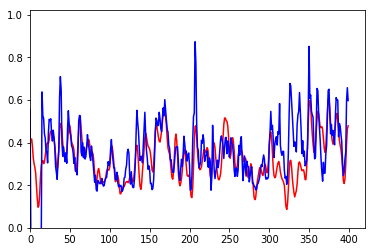

In [27]:
plt.plot(predictions, 'r')
plt.plot(targets_o, 'b')
plt.axis([0.0,420,0.0,1.02])
plt.show()